<a href="https://colab.research.google.com/github/BSriVaishnavi/Avocados/blob/main/walmart_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [50]:
#Importing the dataset

df = pd.read_csv('Walmart.csv')

#df.drop(['car name'], axis=1, inplace=True)
display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106


Inference: The Datset consists of 8 features & 6435 samples.


In [51]:
# Reframing the columns

df.Date = pd.to_datetime(df.Date, format='%d-%m-%Y')  # Specify the format

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

# Optional: Creating Monthly Quarter column if needed
# df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
#                                       8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

df.drop(['Date'], axis=1, inplace=True)

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()


Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  weekday  month  year  
0         8.106        4      2  2010  
1         8.106        4      2  2010  
2         8.106        4      2  2010  
3         8.106        4      2  2010  
4         8.106        4      3  2010

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int32  
 8   month         6435 non-null   int32  
 9   year          6435 non-null   int32  
dtypes: float64(5), int32(3), int64(2)
memory usage: 427.4 KB


In [53]:

#Checking number of unique rows in each feature
df.nunique().sort_values()

weekday            1
Holiday_Flag       2
year               3
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [54]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 5 categorical features.


In [55]:
#Checking the stats of all the columns

display(df.describe())


Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  weekday        month         year  
count  6435.000000   6435.000000   6435.0  6435.000000  6435.000000  
mean    171.578394      7.999151      4.0     6.447552  2010.965035  
std      39.356712      1.875885      0.0     3.238308     0.797019  
min     126.064000      3.879000      4.0     1.000000  2010.000000  
25%     131.735000      6.891000      4.0     4.000000  2010.000000  
50%     182.616521      7.874000      4.0     6.000000  2011.000000  
75%     212.743293      8.622000      4.0     9.000000  2012.000000  
max     227.232807     14.313000      4.0    12.000000  2012.000000

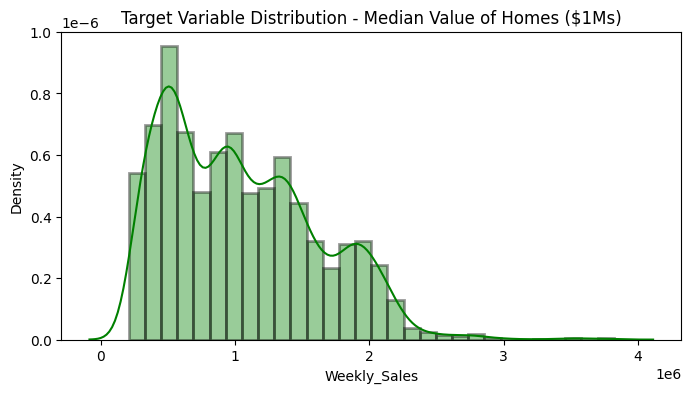

In [56]:
 #Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


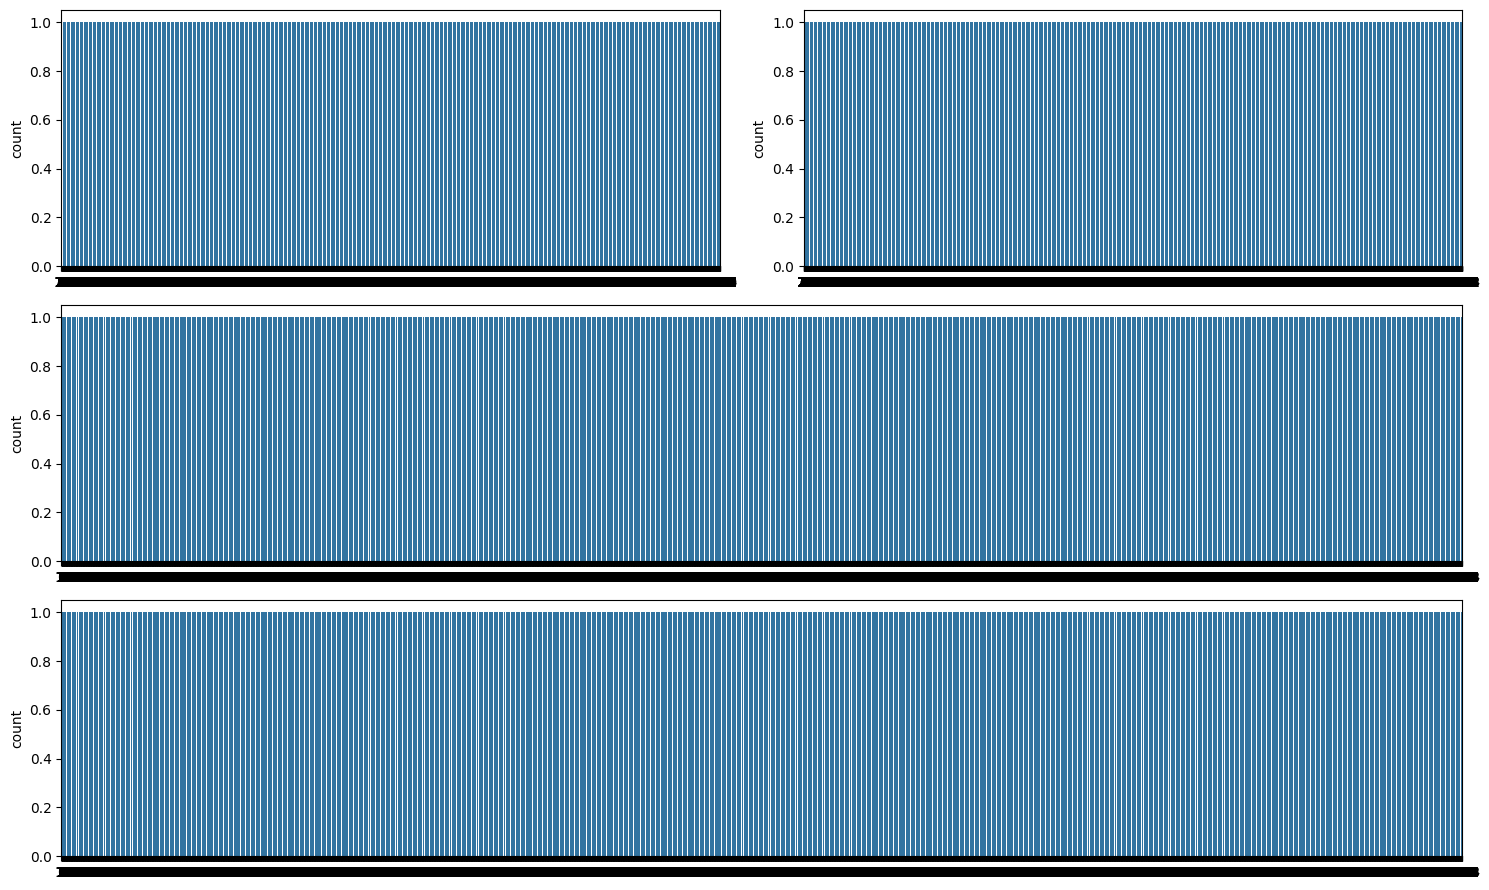

In [57]:
#Visualising the categorical features

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])

plt.tight_layout()
plt.show()

                                                Numeric Features Distribution                                                 


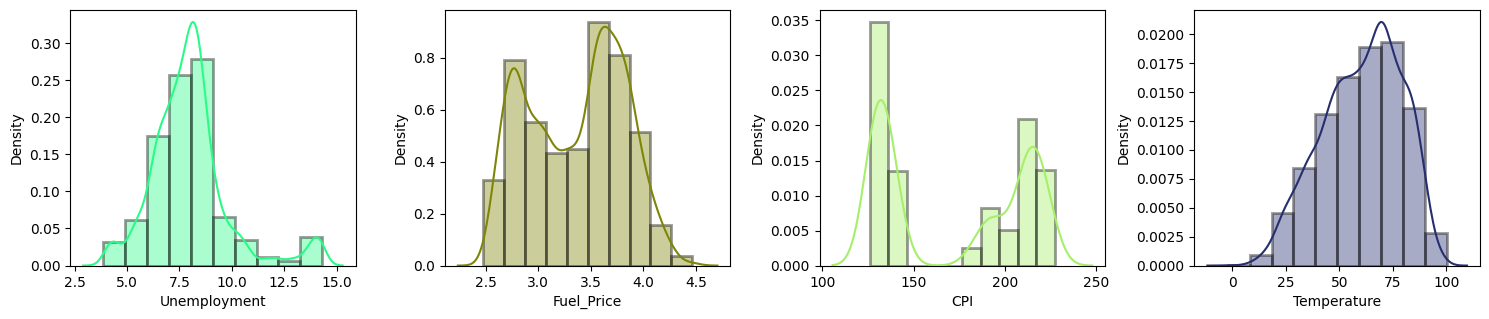

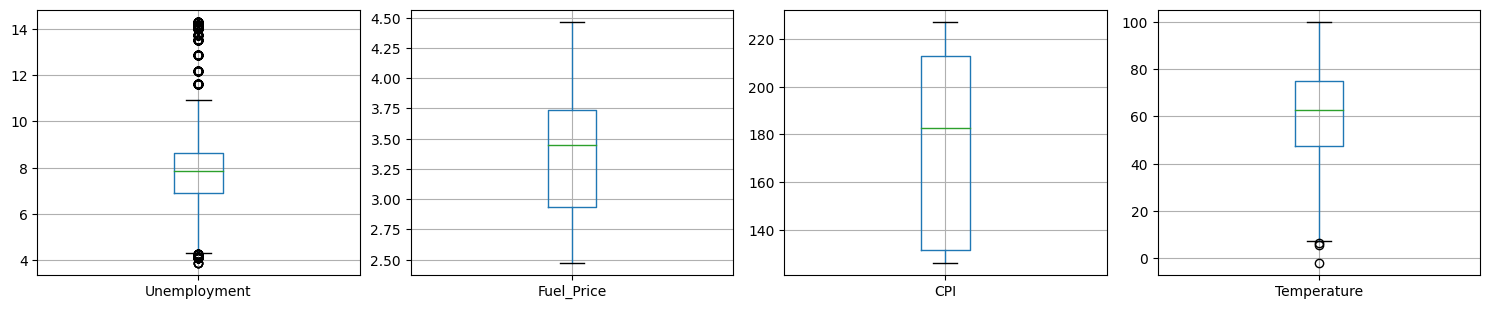

In [58]:
#Visualising the numeric features

print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

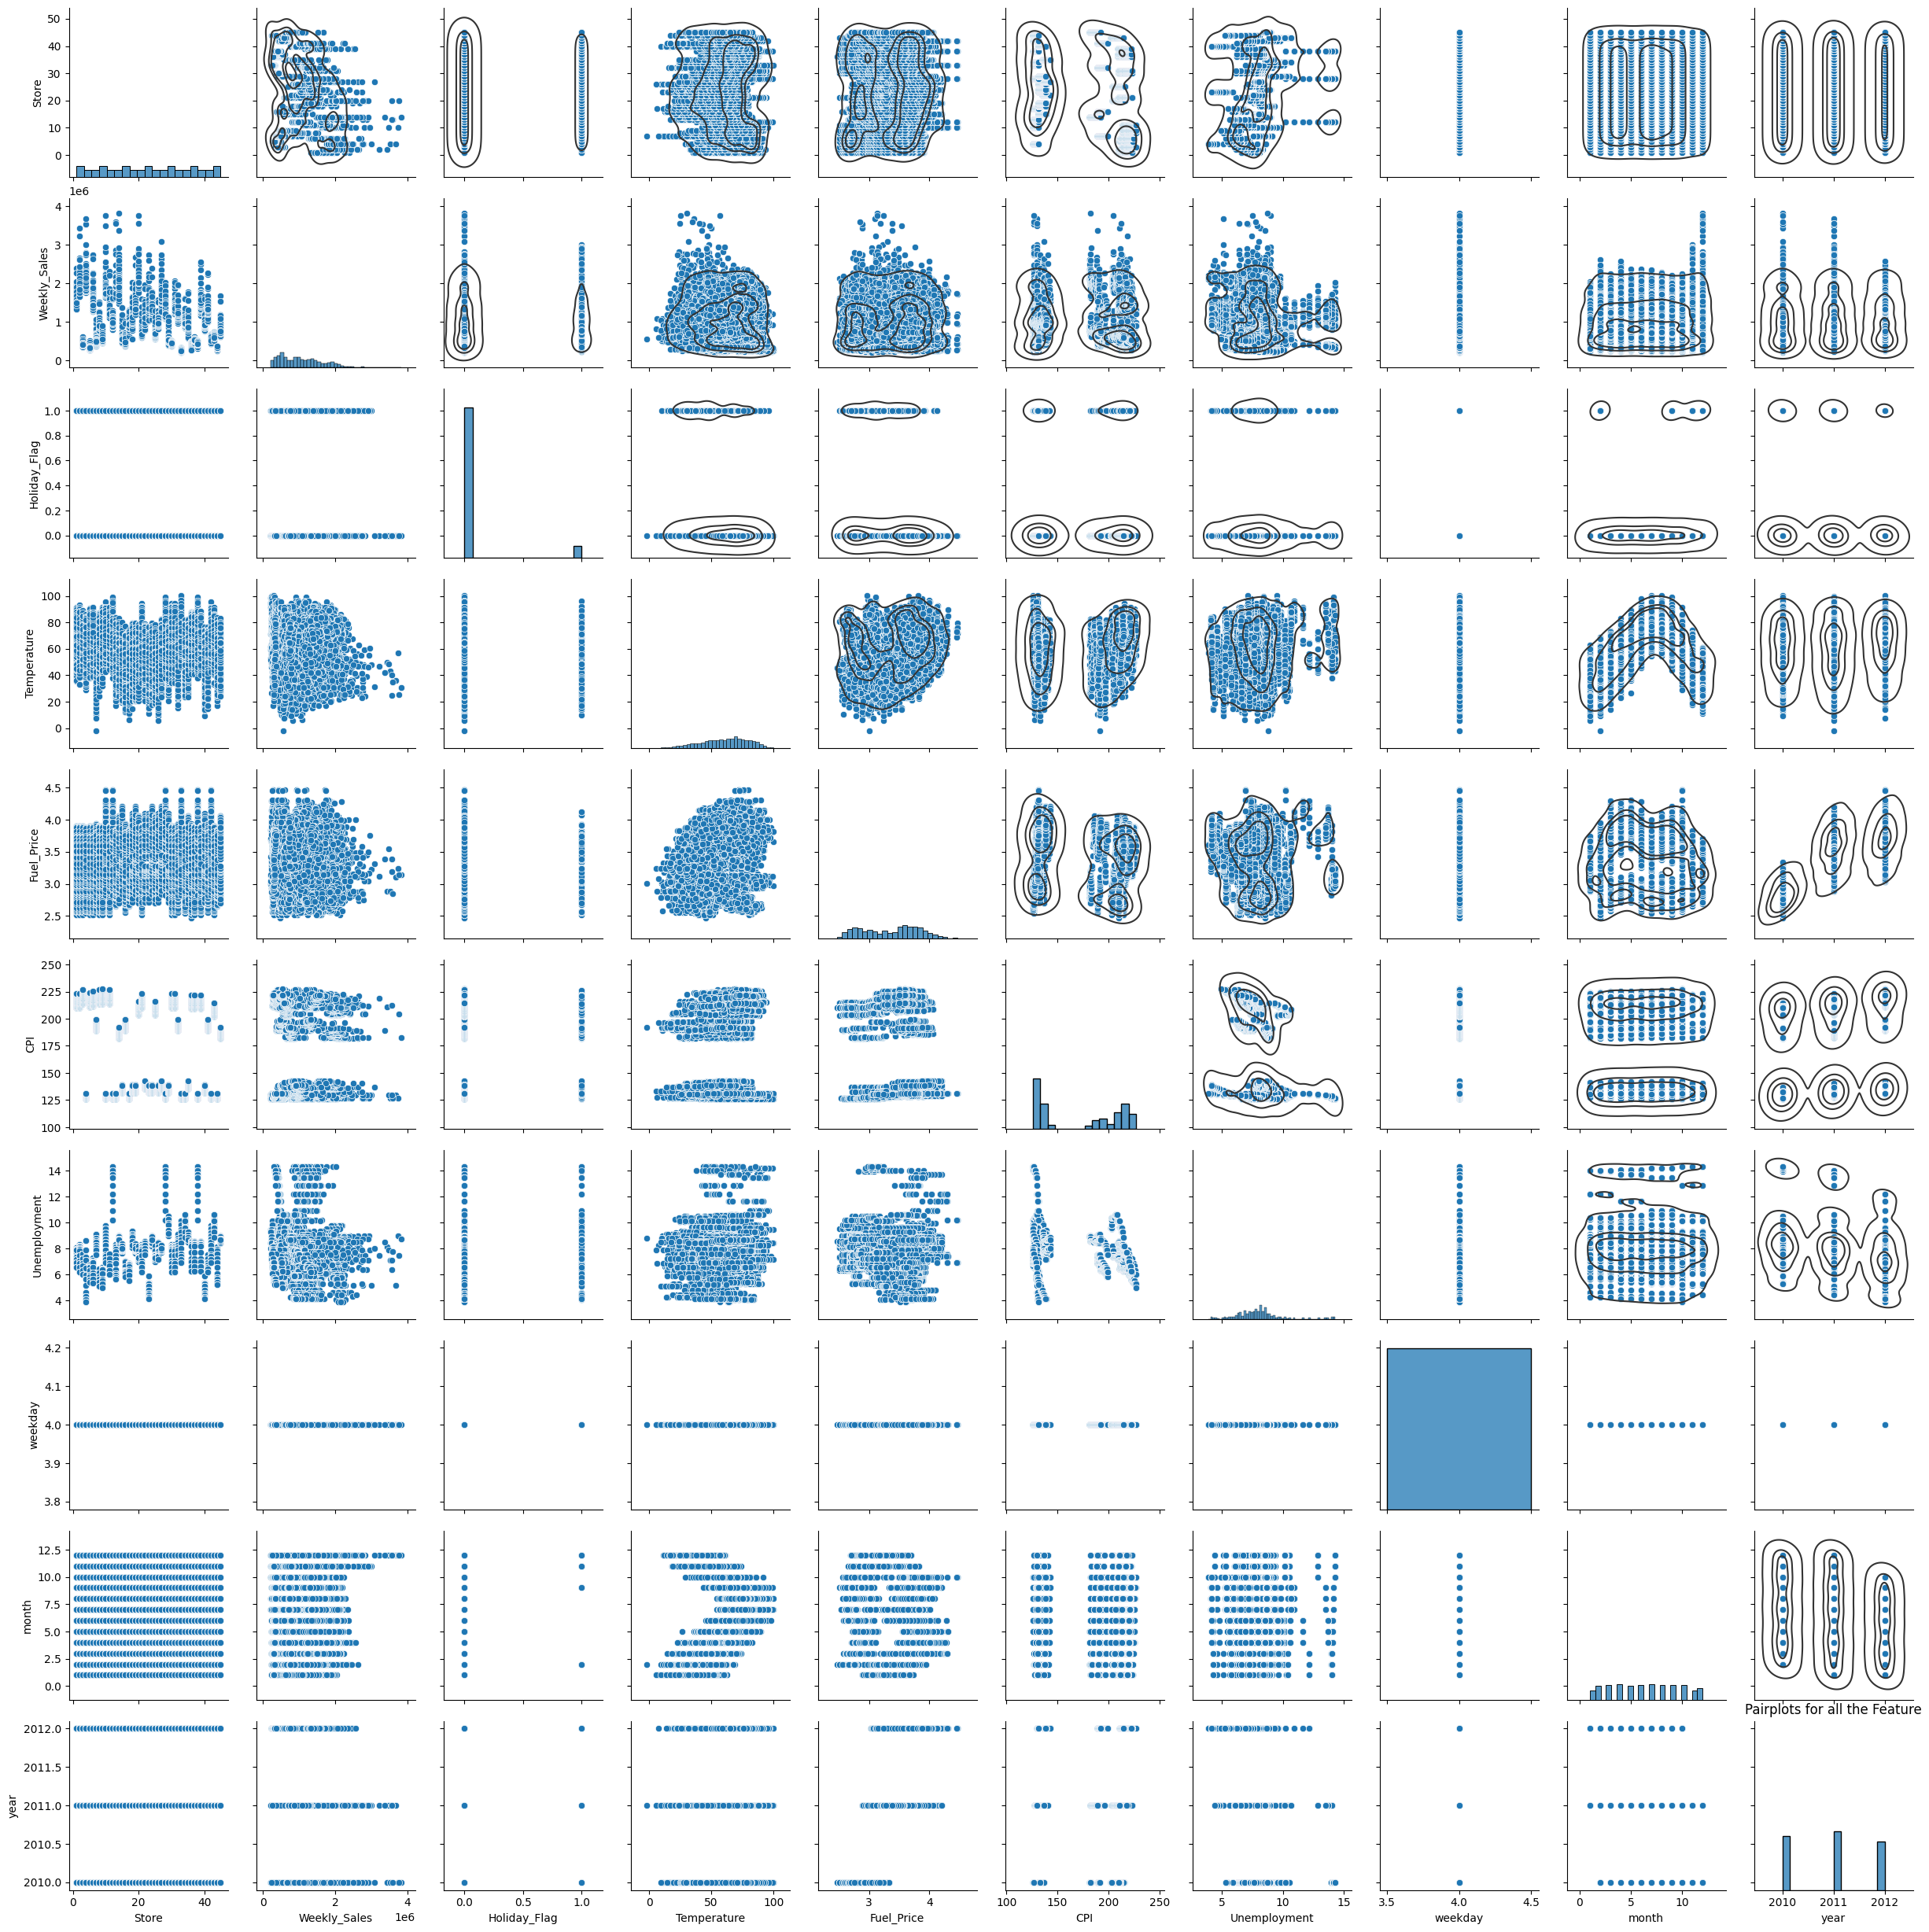

In [59]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()


In [60]:
#Removal of any Duplicate rows

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [61]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


In [62]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
month
Store


(6435, 64)

In [63]:

#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0    1643690.90         False        42.31       2.572  211.096358   
1    1641957.44          True        38.51       2.548  211.242170   
2    1611968.17         False        39.93       2.514  211.289143   
3    1409727.59         False        46.63       2.561  211.319643   
4    1554806.68         False        46.50       2.625  211.350143   

   Unemployment  weekday  year_2011  year_2012  month_2  ...  Store_36  \
0         8.106        4      False      False     True  ...     False   
1         8.106        4      False      False     True  ...     False   
2         8.106        4      False      False     True  ...     False   
3         8.106        4      False      False     True  ...     False   
4         8.106        4      False      False    False  ...     False   

   Store_37  Store_38  Store_39  Store_40  Store_41  Store_42  Store_43  \
0     False     False     False     False     False     False     False   
1     False     False     False     False     False     False     False   
2     False     False     False     False     False     False     False   
3     False     False     False     False     False     False     False   
4     False     False     False     False     False     False     False   

   Store_44  Store_45  
0     False     False  
1     False     False  
2     False     False  
3     False     False  
4     False     False  

[5 rows x 64 columns]


Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


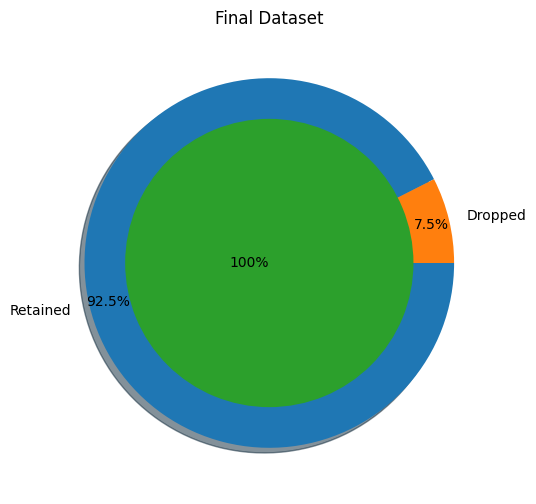


Inference: After the cleanup process, 482 samples were dropped, while retaining 7.49% of the data.


In [64]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [65]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 63) (5953,) 
Training set  --->  (4762, 63) (4762,) 
Testing set   --->  (1191, 63)  (1191,)


In [66]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


Holiday_Flag   Temperature    Fuel_Price           CPI  Unemployment  \
count  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03   
mean  -1.492110e-18 -1.305596e-16 -2.991680e-16 -2.762268e-16 -4.267434e-16   
std    1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00   
min   -2.742012e-01 -2.961575e+00 -1.871814e+00 -1.248731e+00 -2.762670e+00   
25%   -2.742012e-01 -7.314248e-01 -9.886990e-01 -1.076949e+00 -6.783836e-01   
50%   -2.742012e-01  1.062547e-01  1.663112e-01  3.842133e-01  9.596435e-02   
75%   -2.742012e-01  7.731979e-01  8.427860e-01  9.933828e-01  6.138095e-01   
max    3.646958e+00  2.170008e+00  2.469806e+00  1.340791e+00  2.575491e+00   

       weekday     year_2011     year_2012       month_2       month_3  ...  \
count   4762.0  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03  ...   
mean       0.0 -5.520807e-17  1.939743e-17  7.460550e-18  3.618367e-17  ...   
std        0.0  1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  ...   
min        0.0 -7.526270e-01 -6.371530e-01 -2.982532e-01 -3.166659e-01  ...   
25%        0.0 -7.526270e-01 -6.371530e-01 -2.982532e-01 -3.166659e-01  ...   
50%        0.0 -7.526270e-01 -6.371530e-01 -2.982532e-01 -3.166659e-01  ...   
75%        0.0  1.328679e+00  1.569482e+00 -2.982532e-01 -3.166659e-01  ...   
max        0.0  1.328679e+00  1.569482e+00  3.352856e+00  3.157903e+00  ...   

           Store_36      Store_37      Store_38      Store_39      Store_40  \
count  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03   
mean   1.529413e-17  4.923963e-17  8.952659e-18  1.342899e-17 -3.730275e-18   
std    1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00   
min   -1.573123e-01 -1.587085e-01 -4.351484e-02 -1.580118e-01 -1.307162e-01   
25%   -1.573123e-01 -1.587085e-01 -4.351484e-02 -1.580118e-01 -1.307162e-01   
50%   -1.573123e-01 -1.587085e-01 -4.351484e-02 -1.580118e-01 -1.307162e-01   
75%   -1.573123e-01 -1.587085e-01 -4.351484e-02 -1.580118e-01 -1.307162e-01   
max    6.356783e+00  6.300861e+00  2.298067e+01  6.328643e+00  7.650163e+00   

           Store_41      Store_42      Store_43      Store_44      Store_45  
count  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03  4.762000e+03  
mean  -1.492110e-17  3.730275e-17 -2.984220e-17 -4.774752e-17  2.499284e-17  
std    1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  1.000105e+00  
min   -1.537717e-01 -1.573123e-01 -1.628322e-01 -1.551967e-01 -1.523346e-01  
25%   -1.537717e-01 -1.573123e-01 -1.628322e-01 -1.551967e-01 -1.523346e-01  
50%   -1.537717e-01 -1.573123e-01 -1.628322e-01 -1.551967e-01 -1.523346e-01  
75%   -1.537717e-01 -1.573123e-01 -1.628322e-01 -1.551967e-01 -1.523346e-01  
max    6.503146e+00  6.356783e+00  6.141290e+00  6.443435e+00  6.564495e+00  

[8 rows x 63 columns]


                                          Standardardization on Testing set                                          


Holiday_Flag  Temperature   Fuel_Price          CPI  Unemployment  \
count   1191.000000  1191.000000  1191.000000  1191.000000   1191.000000   
mean       0.005646     0.044406     0.075113     0.021041     -0.050953   
std        1.009885     1.000220     0.971917     1.004644      1.010206   
min       -0.274201    -2.857425    -1.780457    -1.248731     -2.762670   
25%       -0.274201    -0.657516    -0.852751    -1.077025     -0.699355   
50%       -0.274201     0.187351     0.298996     0.393492      0.058860   
75%       -0.274201     0.818764     0.844961     1.019967      0.611390   
max        3.646958     2.035481     2.469806     1.345814      2.575491   

       weekday    year_2011    year_2012      month_2      month_3  ...  \
count   1191.0  1191.000000  1191.000000  1191.000000  1191.000000  ...   
mean       0.0     0.052984     0.065042     0.026699    -0.019096  ...   
std        0.0     1.014188     1.028250     1.040072     0.972715  ...   
min        0.0    -0.752627    -0.637153    -0.298253    -0.316666  ...   
25%        0.0    -0.752627    -0.637153    -0.298253    -0.316666  ...   
50%        0.0    -0.752627    -0.637153    -0.298253    -0.316666  ...   
75%        0.0     1.328679     1.569482    -0.298253    -0.316666  ...   
max        0.0     1.328679     1.569482     3.352856     3.157903  ...   

          Store_36     Store_37     Store_38     Store_39     Store_40  \
count  1191.000000  1191.000000  1191.000000  1191.000000  1191.000000   
mean     -0.004168    -0.017693     0.111140    -0.010959    -0.000055   
std       0.987401     0.944330     1.881448     0.965939     1.000214   
min      -0.157312    -0.158708    -0.043515    -0.158012    -0.130716   
25%      -0.157312    -0.158708    -0.043515    -0.158012    -0.130716   
50%      -0.157312    -0.158708    -0.043515    -0.158012    -0.130716   
75%      -0.157312    -0.158708    -0.043515    -0.158012    -0.130716   
max       6.356783     6.300861    22.980668     6.328643     7.650163   

          Store_41     Store_42     Store_43     Store_44     Store_45  
count  1191.000000  1191.000000  1191.000000  1191.000000  1191.000000  
mean      0.030677    -0.004168    -0.056970     0.016556     0.045053  
std       1.093088     0.987401     0.810380     1.051077     1.134875  
min      -0.153772    -0.157312    -0.162832    -0.155197    -0.152335  
25%      -0.153772    -0.157312    -0.162832    -0.155197    -0.152335  
50%      -0.153772    -0.157312    -0.162832    -0.155197    -0.152335  
75%      -0.153772    -0.157312    -0.162832    -0.155197    -0.152335  
max       6.503146     6.356783     6.141290     6.443435     6.564495  

[8 rows x 63 columns]

                                       Correlation Matrix                                       


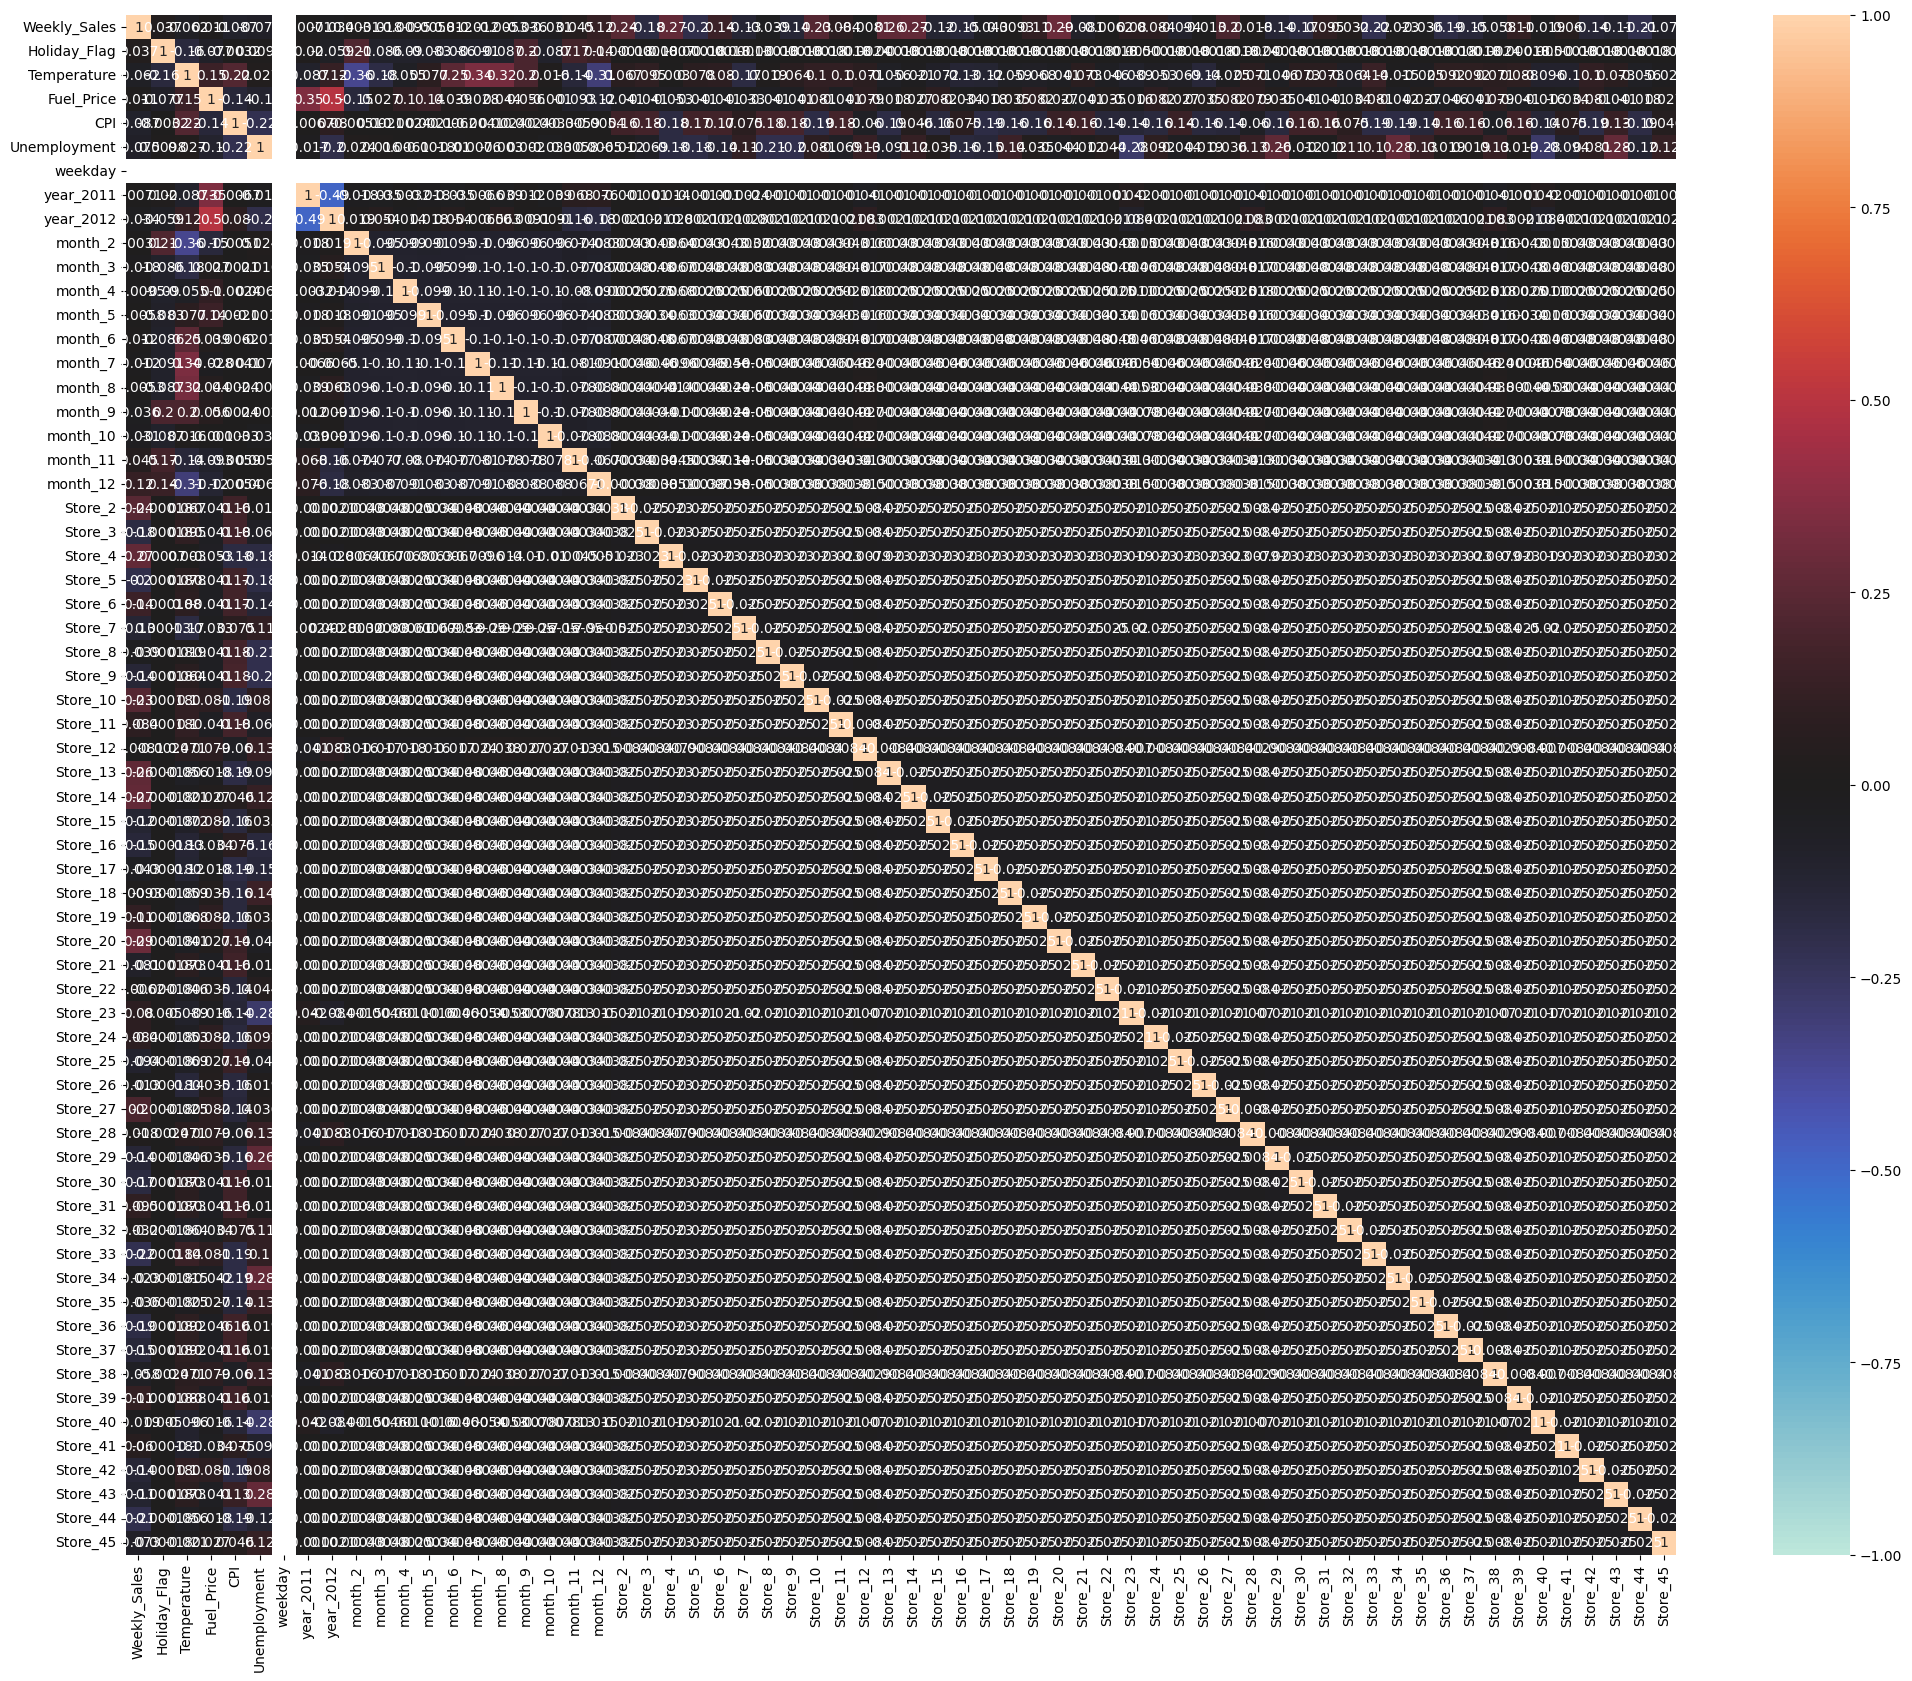

In [67]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [68]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1155.
Date:                Mon, 22 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:21:13   Log-Likelihood:                -63223.
No. Observations:                4762   AIC:                         1.266e+05
Df Residuals:                    4699   BIC:                         1.270e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.048e+06   2059.199    508.743      0.000    1.04e+06    1.05e+06
Holiday_Flag  8059.9214   2279.678      3.536      0.000    3590.684    1.25e+04
Temperature   1.769e+04   7235.809      2.445      0.015    3504.204    3.19e+04
Fuel_Price   -1296.0299   6741.498     -0.192      0.848   -1.45e+04    1.19e+04
CPI           1.577e+05   7.06e+04      2.233      0.026    1.93e+04    2.96e+05
Unemployment -5.424e+04   7171.270     -7.564      0.000   -6.83e+04   -4.02e+04
weekday       6.005e-11   1.03e-10      0.581      0.561   -1.42e-10    2.63e-10
year_2011    -1.523e+04   7195.844     -2.116      0.034   -2.93e+04   -1120.441
year_2012    -2.805e+04   1.04e+04     -2.700      0.007   -4.84e+04   -7678.312
month_2       3.105e+04   3383.632      9.177      0.000    2.44e+04    3.77e+04
month_3       2.123e+04   4074.185      5.211      0.000    1.32e+04    2.92e+04
month_4       2.326e+04   4956.542      4.693      0.000    1.35e+04     3.3e+04
month_5       2.165e+04   5142.688      4.210      0.000    1.16e+04    3.17e+04
month_6        2.84e+04   5716.385      4.968      0.000    1.72e+04    3.96e+04
month_7       1.747e+04   6274.423      2.785      0.005    5171.630    2.98e+04
month_8        2.02e+04   6207.060      3.255      0.001    8034.143    3.24e+04
month_9       2761.7459   5723.463      0.483      0.629   -8458.925     1.4e+04
month_10      9450.4348   5144.900      1.837      0.066    -635.983    1.95e+04
month_11      4.162e+04   3902.022     10.666      0.000     3.4e+04    4.93e+04
month_12      8.575e+04   3975.296     21.570      0.000     7.8e+04    9.35e+04
Store_2       5.429e+04   2849.085     19.056      0.000    4.87e+04    5.99e+04
Store_3      -1.816e+05   3037.660    -59.778      0.000   -1.88e+05   -1.76e+05
Store_4       1.148e+05    2.3e+04      4.999      0.000    6.97e+04     1.6e+05
Store_5      -1.899e+05   3023.242    -62.806      0.000   -1.96e+05   -1.84e+05
Store_6      -7322.3757   3058.926     -2.394      0.017   -1.33e+04   -1325.446
Store_7      -1.284e+05   7132.924    -18.005      0.000   -1.42e+05   -1.14e+05
Store_8      -1.142e+05   3392.659    -33.653      0.000   -1.21e+05   -1.08e+05
Store_9      -1.589e+05   3194.275    -49.741      0.000   -1.65e+05   -1.53e+05
Store_10      1.075e+05   2.39e+04      4.503      0.000    6.07e+04    1.54e+05
Store_11     -3.776e+04   3058.338    -12.347      0.000   -4.38e+04   -3.18e+04
Store_12     -2928.8960   9460.509     -0.310      0.757   -2.15e+04    1.56e+04
Store_13      1.176e+05    2.4e+04      4.891      0.000    7.04e+04    1.65e+05
Store_14      9.566e+04   8660.998     11.045      0.000    7.87e+04    1.13e+05
Store_15     -9.031e+04   2.27e+04     -3.975      0.000   -1.35e+05   -4.58e+04
Store_16     -1.522e+05   7079.401    -21.498      0.000   -1.66e+05   -1.38e+05
Store

Dropped Features -->  ['CPI', 'year_2012', 'Temperature', 'Unemployment', 'month_4', 'Store_30', 'month_2', 'Store_27', 'Fuel_Price', 'Store_29', 'month_7', 'Store_32', 'month_9', 'Store_8', 'Store_25', 'month_8', 'Store_43', 'Store_17', 'month_10', 'Store_18', 'Holiday_Flag', 'Store_19', 'Store_20', 'Store_16', 'Store_21', 'Store_22', 'month_3', 'Store_15', 'Store_36', 'Store_14', 'Store_45', 'Store_13', 'month_5', 'year_2011', 'month_6', 'Store_24', 'Store_26', 'Store_44', 'Store_42', 'Store_41', 'month_11', 'Store_40', 'Store_39', 'Store_11', 'Store_35', 'Store_10', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6']


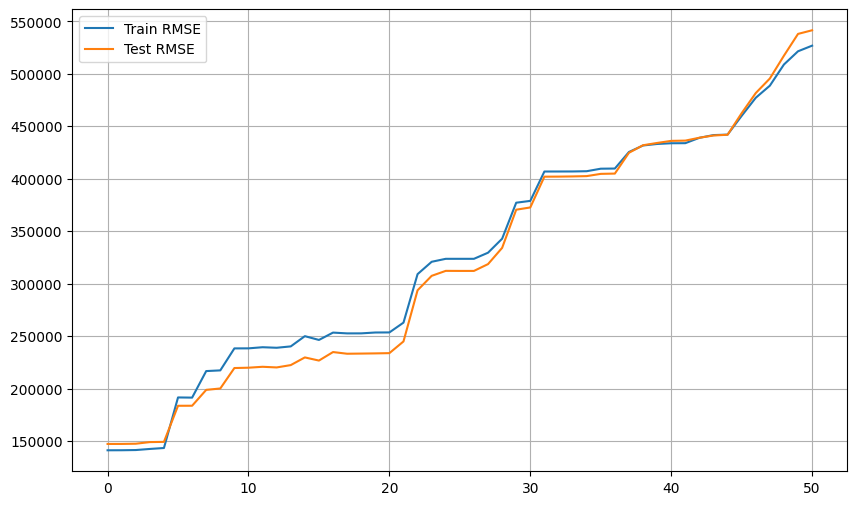

In [69]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))

        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)

print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

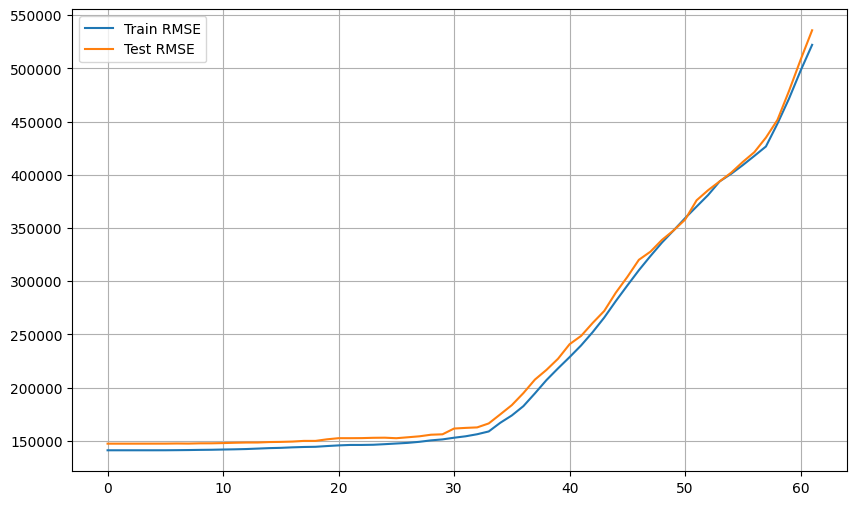

In [70]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()


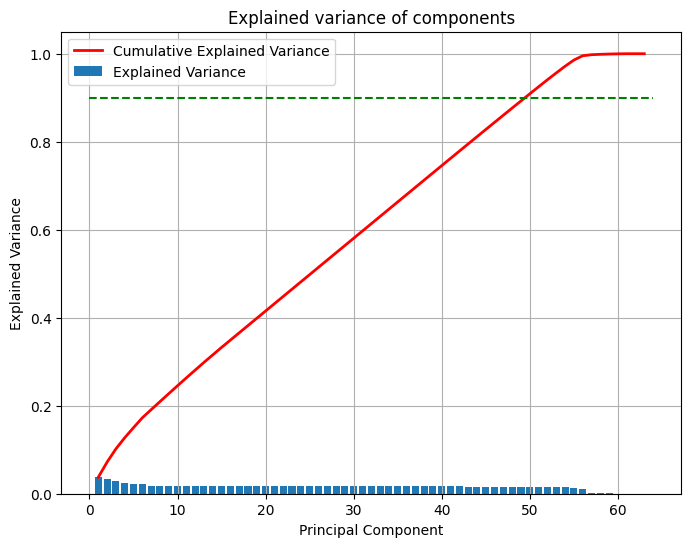

In [71]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

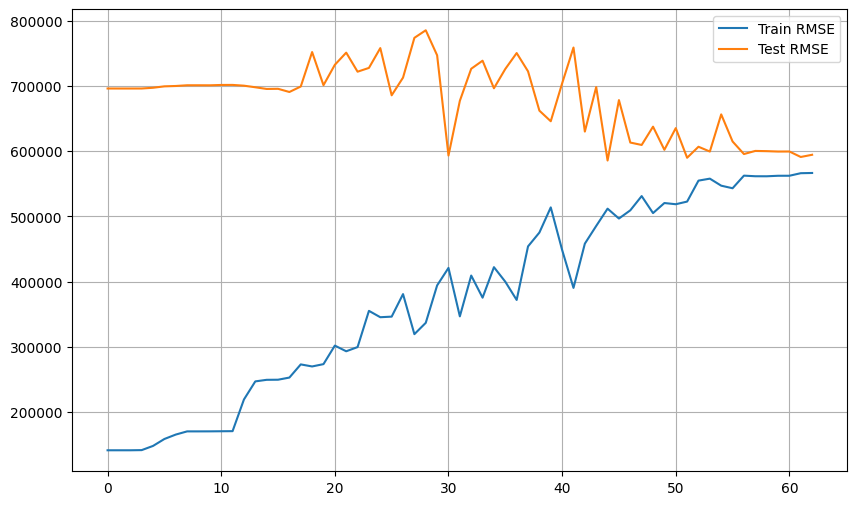

In [72]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)

    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Standardize the training data
scaler = StandardScaler()
Train_X_std = scaler.fit_transform(Train_X)
Test_X_std = scaler.transform(Test_X)

# Convert standardized data back to DataFrames
Train_X_std = pd.DataFrame(Train_X_std, columns=Train_X.columns)
Test_X_std = pd.DataFrame(Test_X_std, columns=Test_X.columns)

# Shortlisting the selected features with RFE
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=Train_X_std.shape[1] - 28)  # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:, rfe.support_], Train_Y)

# Print the selected features
print(Train_X_std.loc[:, rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:, rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:, rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:, rfe.support_]
Test_X_std = Test_X_std.loc[:, rfe.support_]


Index(['Temperature', 'CPI', 'month_11', 'month_12', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_7', 'Store_8', 'Store_9', 'Store_10',
       'Store_11', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_19',
       'Store_20', 'Store_21', 'Store_23', 'Store_24', 'Store_25', 'Store_27',
       'Store_29', 'Store_30', 'Store_32', 'Store_33', 'Store_36', 'Store_37',
       'Store_38', 'Store_42', 'Store_43', 'Store_44', 'Store_45'],
      dtype='object')
150459.66166466865
155774.02431252034


In [74]:
#Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-28)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

417729.9813067724
421251.22619825567


In [75]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

ValueError: 'a' cannot be empty unless no samples are taken

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Ensure Train_X_std is a DataFrame with columns
# Ensure Train_X_std and Test_X_std are standardized DataFrames

# Example DataFrame for demonstration purposes
# Train_X_std = pd.DataFrame(...)
# Train_Y = pd.Series(...)
# Test_X_std = pd.DataFrame(...)
# Test_Y = pd.Series(...)

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])

# Ensure there are columns with 50 or more unique values, or handle the case where there are none
valid_columns = Train_X_std.loc[:, Train_X_std.nunique() >= 50].columns.values
if len(valid_columns) >= 2:
    rc = np.random.choice(valid_columns, 2, replace=False)
else:
    # Handle the case where there are fewer than 2 valid columns
    rc = Train_X_std.columns[:2]  # Fallback to the first two columns as an example

def Evaluate(n, pred1, pred2):
    # Plotting predicted values alongside the actual data points
    plt.figure(figsize=[15,6])
    for e, i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    # Evaluating the Multiple Linear Regression Model
    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->', round(r2_score(Train_Y, pred1), 20))
    print('Residual Sum of Squares (RSS) on Training set  --->', round(np.sum(np.square(Train_Y - pred1)), 20))
    print('Mean Squared Error (MSE) on Training set       --->', round(mean_squared_error(Train_Y, pred1), 20))
    print('Root Mean Squared Error (RMSE) on Training set --->', round(np.sqrt(mean_squared_error(Train_Y, pred1)), 20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->', round(r2_score(Test_Y, pred2), 20))
    print('Residual Sum of Squares (RSS) on Testing set  --->', round(np.sum(np.square(Test_Y - pred2)), 20))
    print('Mean Squared Error (MSE) on Testing set       --->', round(mean_squared_error(Test_Y, pred2), 20))
    print('Root Mean Squared Error (RMSE) on Testing set --->', round(np.sqrt(mean_squared_error(Test_Y, pred2)), 20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-R2'] = round(r2_score(Train_Y, pred1), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-R2'] = round(r2_score(Test_Y, pred2), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RSS'] = round(np.sum(np.square(Train_Y - pred1)), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RSS'] = round(np.sum(np.square(Test_Y - pred2)), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-MSE'] = round(mean_squared_error(Train_Y, pred1), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-MSE'] = round(mean_squared_error(Test_Y, pred2), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RMSE'] = round(np.sqrt(mean_squared_error(Train_Y, pred1)), 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)), 20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')
    plt.subplot(1,2,2)
    plt.scatter(Train_Y, pred1)
    plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

# Example usage
# pred1 = ...  # Predictions on training data
# pred2 = ...  # Predictions on test data
# Evaluate(0, pred1, pred2)


<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.2981121379


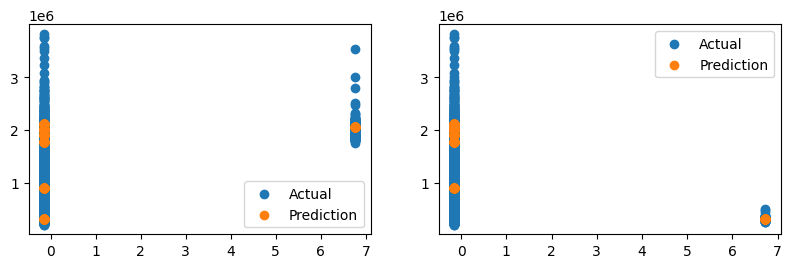



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4608126886880588
Residual Sum of Squares (RSS) on Training set  ---> 830961082139533.8
Mean Squared Error (MSE) on Training set       ---> 174498337282.55643
Root Mean Squared Error (RMSE) on Training set ---> 417729.9813067724

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.4812057148208473
Residual Sum of Squares (RSS) on Testing set  ---> 211346041328078.94
Mean Squared Error (MSE) on Testing set       ---> 177452595573.53397
Root Mean Squared Error (RMSE) on Testing set ---> 421251.22619825567

--------------------Residual Plots--------------------


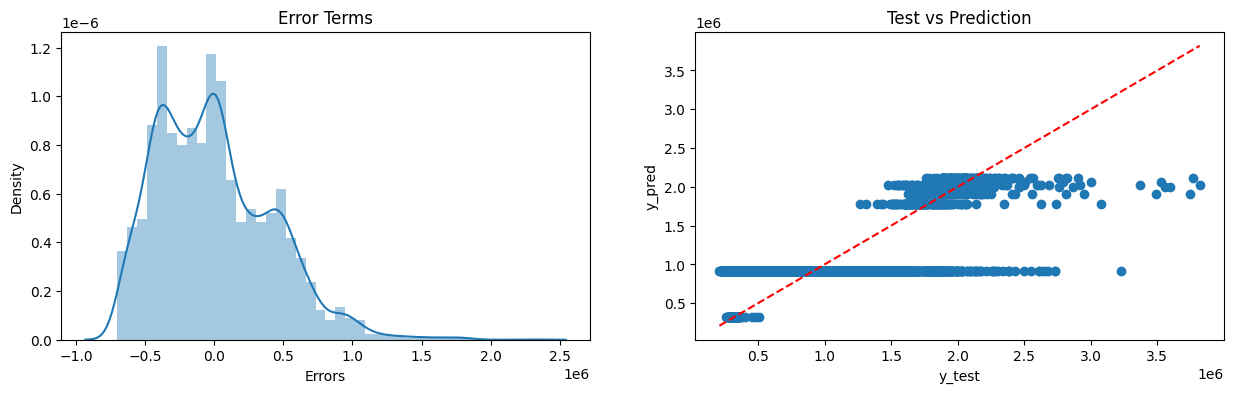

In [77]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.2981121379


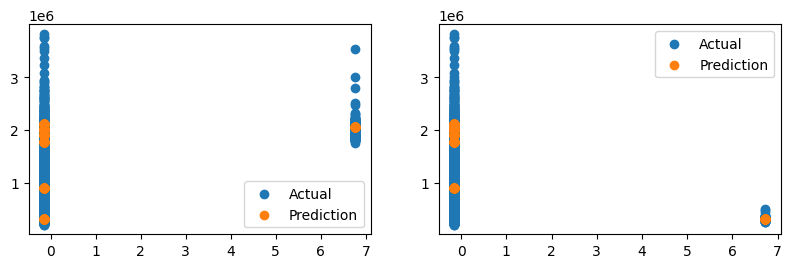



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4608126640583091
Residual Sum of Squares (RSS) on Training set  ---> 830961120097332.5
Mean Squared Error (MSE) on Training set       ---> 174498345253.53476
Root Mean Squared Error (RMSE) on Training set ---> 417729.9908475985

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.481205695539183
Residual Sum of Squares (RSS) on Testing set  ---> 211346049183029.44
Mean Squared Error (MSE) on Testing set       ---> 177452602168.79047
Root Mean Squared Error (RMSE) on Testing set ---> 421251.2340264305

--------------------Residual Plots--------------------


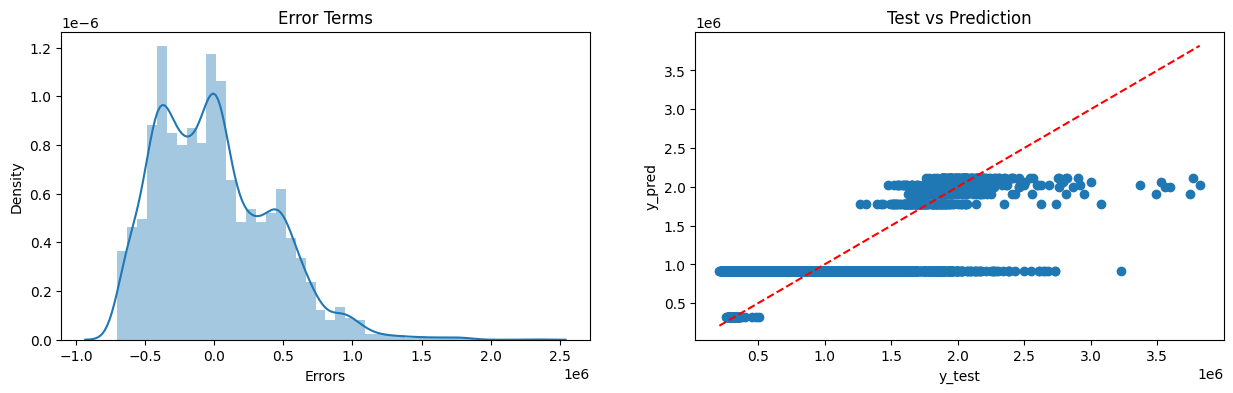

In [78]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.2981121379


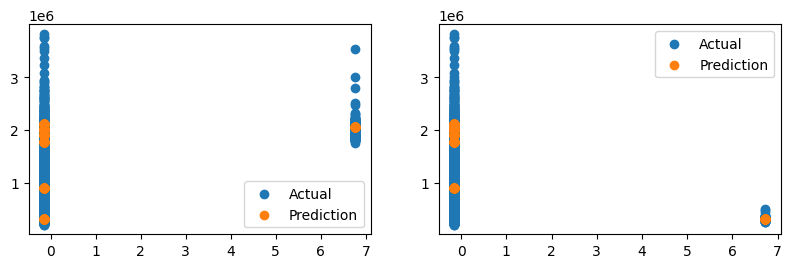



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.46081268866478087
Residual Sum of Squares (RSS) on Training set  ---> 830961082175408.2
Mean Squared Error (MSE) on Training set       ---> 174498337290.08994
Root Mean Squared Error (RMSE) on Training set ---> 417729.9813157897

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.48120570984191025
Residual Sum of Squares (RSS) on Testing set  ---> 211346043356394.72
Mean Squared Error (MSE) on Testing set       ---> 177452597276.5699
Root Mean Squared Error (RMSE) on Testing set ---> 421251.2282196574

--------------------Residual Plots--------------------


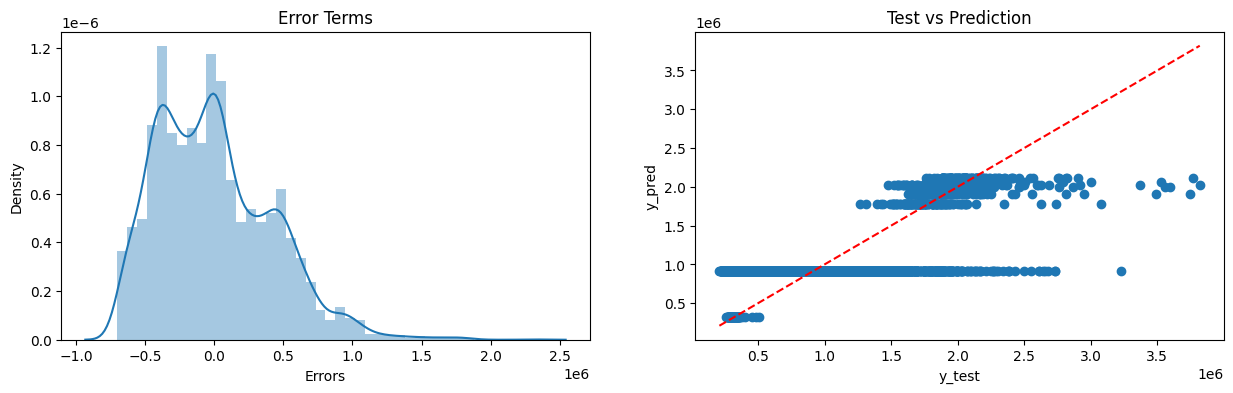

In [79]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.2981121379


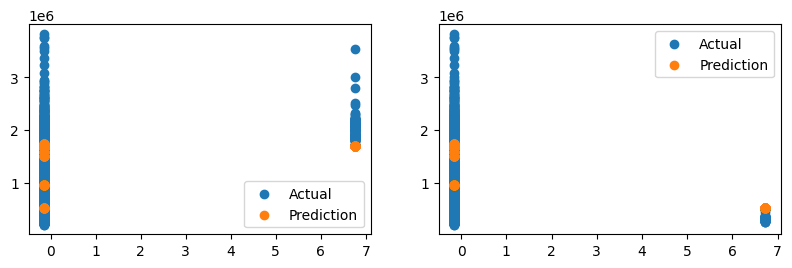



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.40297171132830234
Residual Sum of Squares (RSS) on Training set  ---> 920101905987788.1
Mean Squared Error (MSE) on Training set       ---> 193217535906.71735
Root Mean Squared Error (RMSE) on Training set ---> 439565.1668486907

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.4214860011378299
Residual Sum of Squares (RSS) on Testing set  ---> 235674615170779.44
Mean Squared Error (MSE) on Testing set       ---> 197879609715.18008
Root Mean Squared Error (RMSE) on Testing set ---> 444836.6101336311

--------------------Residual Plots--------------------


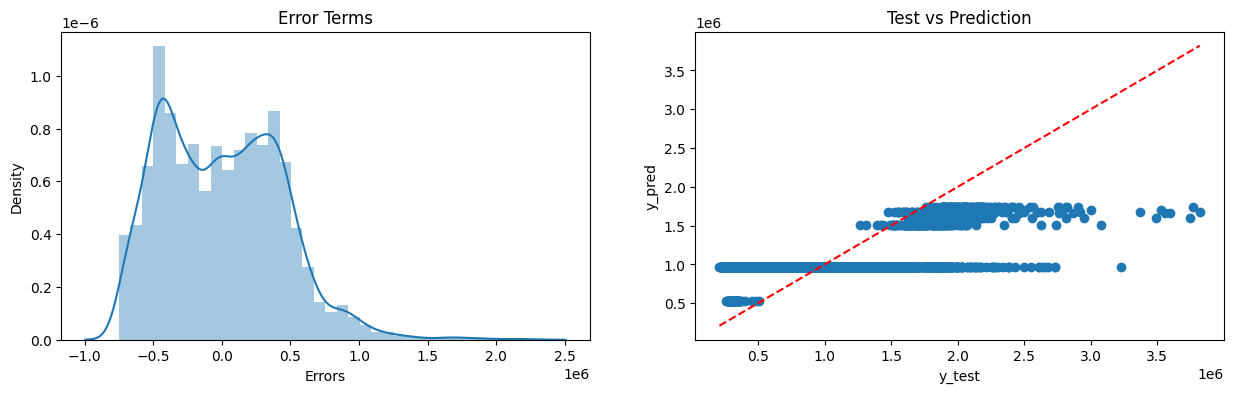

In [80]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

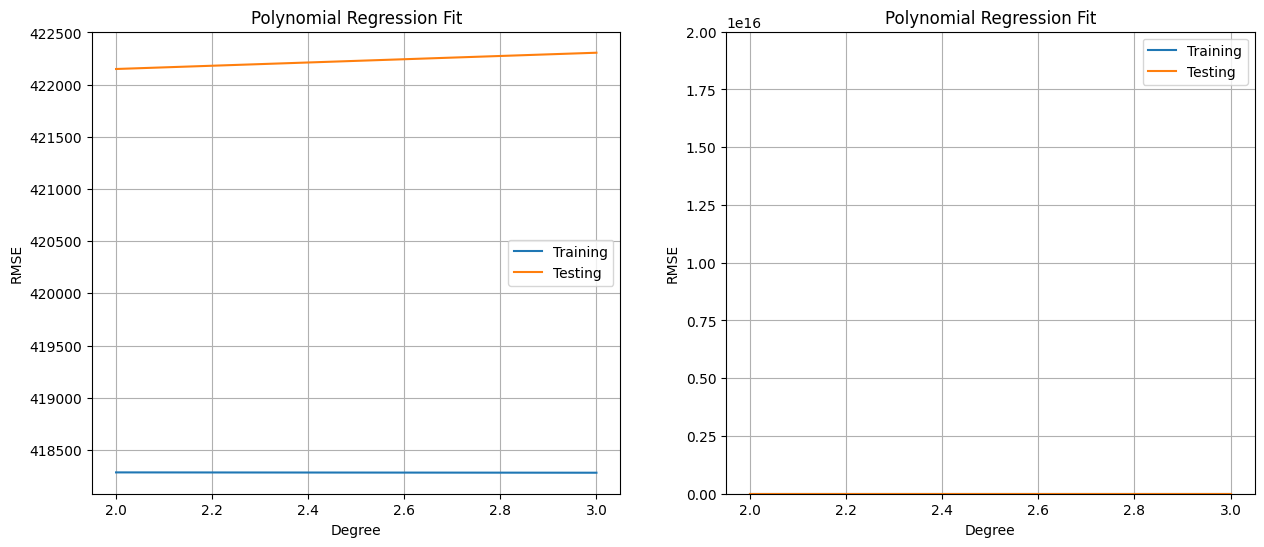

In [81]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)

    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))

    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()


<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [166445.12330771 -86523.40084499 148667.72525808 164799.07057563
 167583.61302918 181481.93714673 134936.61953222]
The Intercept of the Regresion Model was found to be  1047603.2981121379


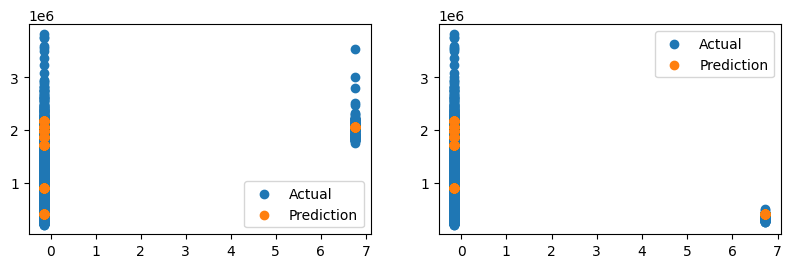



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.45937950362658087
Residual Sum of Squares (RSS) on Training set  ---> 833169815514015.9
Mean Squared Error (MSE) on Training set       ---> 174962162014.70303
Root Mean Squared Error (RMSE) on Training set ---> 418284.7857796205

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.47898939682313746
Residual Sum of Squares (RSS) on Testing set  ---> 212248923353809.8
Mean Squared Error (MSE) on Testing set       ---> 178210682916.7169
Root Mean Squared Error (RMSE) on Testing set ---> 422150.0715583463

--------------------Residual Plots--------------------


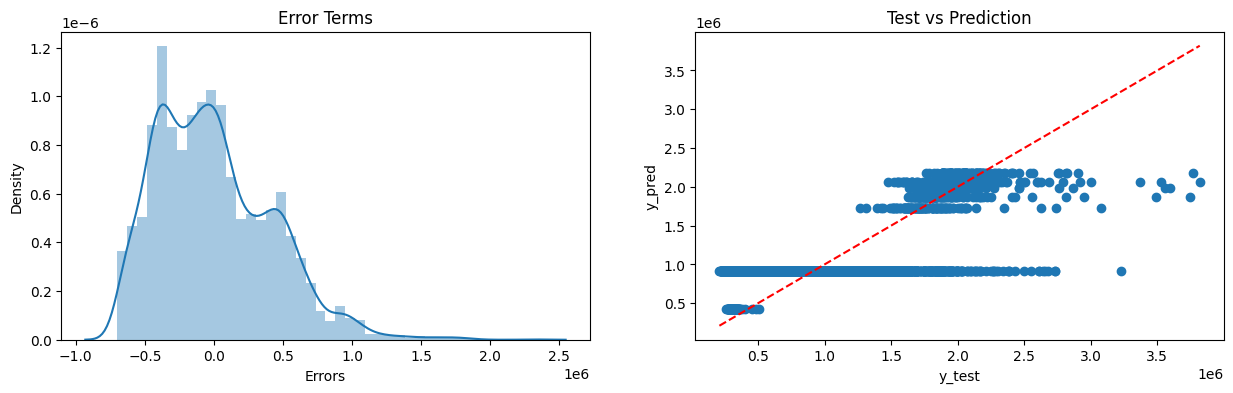

In [82]:

#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

In [83]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

Train-R2   Test-R2     Train-RSS  \
Multiple Linear Regression (MLR)  0.460813  0.481206  8.309611e+14   
Ridge Linear Regression (RLR)     0.460813  0.481206  8.309611e+14   
Lasso Linear Regression (LLR)     0.460813  0.481206  8.309611e+14   
Elastic-Net Regression (ENR)      0.402972  0.421486  9.201019e+14   
Polynomial Regression (PNR)       0.459380  0.478989  8.331698e+14   

                                      Test-RSS     Train-MSE      Test-MSE  \
Multiple Linear Regression (MLR)  2.113460e+14  1.744983e+11  1.774526e+11   
Ridge Linear Regression (RLR)     2.113460e+14  1.744983e+11  1.774526e+11   
Lasso Linear Regression (LLR)     2.113460e+14  1.744983e+11  1.774526e+11   
Elastic-Net Regression (ENR)      2.356746e+14  1.932175e+11  1.978796e+11   
Polynomial Regression (PNR)       2.122489e+14  1.749622e+11  1.782107e+11   

                                     Train-RMSE      Test-RMSE  
Multiple Linear Regression (MLR)  417729.981307  421251.226198  
Ridge Linear Regression (RLR)     417729.990848  421251.234026  
Lasso Linear Regression (LLR)     417729.981316  421251.228220  
Elastic-Net Regression (ENR)      439565.166849  444836.610134  
Polynomial Regression (PNR)       418284.785780  422150.071558

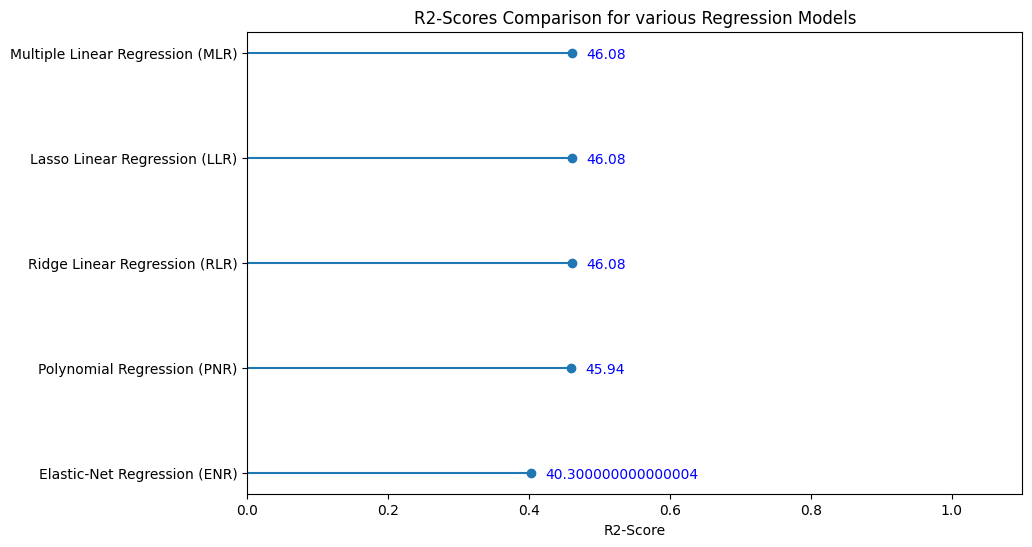

In [84]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

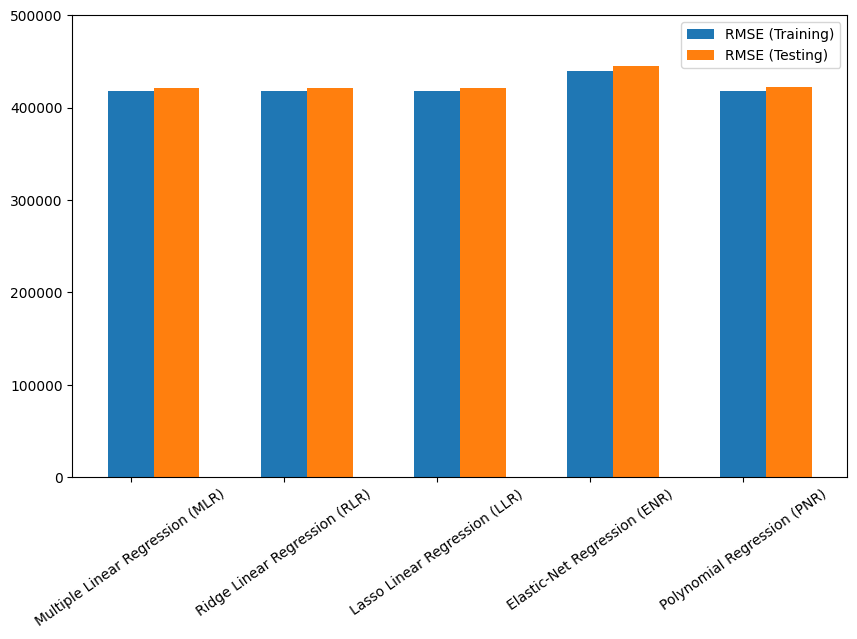

In [85]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,500000])
plt.show()